In [70]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
from torch import nn
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [64]:
ROOT_DIR = "MNIST"   
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
TEST_SIZE = 0.2
IMG_SIZE = (28, 28)
RANDOM_SEED = 42
TARGET_SIZE = None
N_CLASSES = 10


Preprocessing

In [ ]:
def load_dataset():
    data_path = ROOT_DIR
    train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=torchvision.transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)

    return train_loader

try:
    train_loader = load_dataset()
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")


Dataset loaded successfully


In [ ]:
for images, labels in train_loader:
    print(f'Image batch dimensions: {images.size()}')
    break

Image batch dimensions: torch.Size([64, 3, 28, 28])


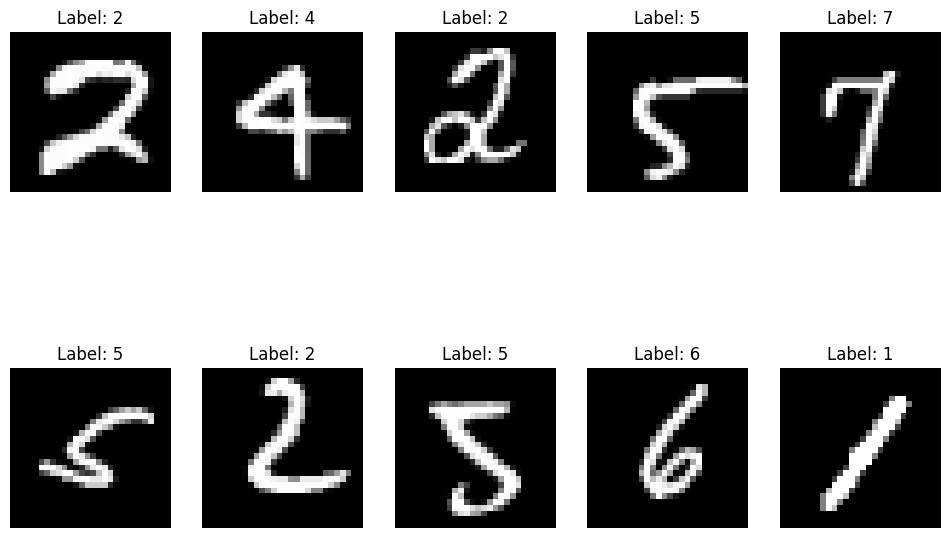

In [38]:
# display first 10 images
fig = plt.figure(figsize=(12, 8))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    img = images[i].detach().cpu()

    if img.shape[0] == 1:
        ax.imshow(img.squeeze(0), cmap='gray')
    else:
        ax.imshow(img.permute(1, 2, 0))
        
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.show()


In [41]:
mnist_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

def get_loader(root, batch_size=64, flatten=False):
    tfms = [mnist_tf]
    if flatten:
        tfms.append(transforms.Lambda(lambda t: t.view(-1)))
    ds = datasets.ImageFolder(root=root, transform=transforms.Compose(tfms))
    return DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

# CNN loader
cnn_loader = get_loader(ROOT_DIR, batch_size=TRAIN_BATCH_SIZE, flatten=False)
x_cnn, y_cnn = next(iter(cnn_loader))
print("CNN batch:", x_cnn.shape) 

# Flat loader
flat_loader = get_loader(ROOT_DIR, batch_size=TRAIN_BATCH_SIZE, flatten=True)
x_flat, y_flat = next(iter(flat_loader))
print("Flat batch:", x_flat.shape)

CNN batch: torch.Size([64, 1, 28, 28])
Flat batch: torch.Size([64, 784])


In [49]:
print("\nCNN loader:")
print(f"Pixel range: min: {float(x_cnn.min())} - max: {float(x_cnn.max())}")
print(f"Labels range: {int(y_cnn.min())} to {int(y_cnn.max())}")

print("\nFlat loader:")
print(f"Pixel range: min: {float(x_flat.min())} - max: {float(x_flat.max())}")
print(f"Labels range: {int(y_flat.min())} to {int(y_flat.max())}")



CNN loader:
Pixel range: min: 0.0 - max: 1.0
Labels range: 0 to 9

Flat loader:
Pixel range: min: 0.0 - max: 1.0
Labels range: 0 to 9


Data Partitioning

In [ ]:
x_list, y_list = [], []

for x, y in flat_loader:
    x_list.append(x.numpy())         
    y_list.append(y.numpy())

x_all = np.concatenate(x_list, axis=0).astype(np.float32)
y_all = np.concatenate(y_list, axis=0).astype(np.int64)

print("All data:", x_all.shape, y_all.shape)

s = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_SEED)
(train_idx, test_idx) = next(s.split(np.zeros(len(y_all)), y_all))

x_train, y_train = x_all[train_idx], y_all[train_idx]
x_test,  y_test  = x_all[test_idx],  y_all[test_idx]

print(f"Train: {x_train.shape}\nTest: {x_test.shape}")

All data: (60000, 784) (60000,)
Train: (48000, 784)
Test: (12000, 784)


In [67]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    return {"accuracy": acc, "precision": prec, "f1": f1}

KNN

In [68]:
def knn(x_train, y_train, x_test_batch, k):
    train_norm = np.sum(x_train**2, axis=1)       
    test_norm  = np.sum(x_test_batch**2, axis=1)

    # squared distances matrix 
    d = test_norm[:, None] + train_norm[None, :] - 2.0 * (x_test_batch @ x_train.T)
    np.maximum(d, 0, out=d)  

    # Get indices of k nearest neighbors
    nn_idx = np.argpartition(d, kth=k-1, axis=1)[:, :k]
    nn_labels = y_train[nn_idx]                            

    # Majority vote per row
    preds = np.empty(nn_labels.shape[0], dtype=np.int64)
    for i, row in enumerate(nn_labels):
        counts = np.bincount(row, minlength=N_CLASSES)
        preds[i] = np.argmax(counts)
    return preds

def run_knn(k=3, batch_size=512):
    preds_list = []
    N = x_test.shape[0]
    for s in range(0, N, batch_size):
        e = min(N, s+batch_size)
        preds_list.append(knn(x_train, y_train, x_test[s:e], k=k))
    return np.concatenate(preds_list)

k_values = [1, 3, 5]
knn_metrics = {}

for k in k_values:
    y_pred_knn_k = run_knn(k=k)
    metrics_knn_k = compute_metrics(y_test, y_pred_knn_k)
    knn_metrics[f"KNN(k={k})"] = metrics_knn_k
    print(f"k={k}: {metrics_knn_k}")


k=1: {'accuracy': 0.9715833333333334, 'precision': 0.9717210930591982, 'f1': 0.9715413532162872}
k=3: {'accuracy': 0.9716666666666667, 'precision': 0.9718128253488216, 'f1': 0.9716091410273187}
k=5: {'accuracy': 0.971, 'precision': 0.9712165876307461, 'f1': 0.9709705451497087}


Naive Bayes

In [103]:
def binarize(X, threshold=0.5):
    return (X > threshold).astype(np.uint8)

def fit_bernoulli(Xb, y, n_classes=N_CLASSES, alpha=1.0):
    N, D = Xb.shape
    class_counts = np.bincount(y, minlength=n_classes)        
    priors = (class_counts + 1) / (N + n_classes)            

    theta = np.empty((n_classes, D), dtype=np.float64)
    for c in range(n_classes):
        Xc = Xb[y == c]                                     
        theta[c] = (Xc.sum(axis=0) + alpha) / (Xc.shape[0] + 2.0 * alpha)

    eps = 1e-12
    theta = np.clip(theta, eps, 1 - eps)
    return priors.astype(np.float64), theta

def predict_bernoulli(Xb, priors, theta, batch_size=2048):
    log_priors = np.log(priors)                    
    log_theta = np.log(theta)                       
    log_1m_theta = np.log(1.0 - theta)            

    N = Xb.shape[0]
    preds = np.empty(N, dtype=np.int64)

    for s in range(0, N, batch_size):
        e = min(N, s + batch_size)
        Xbatch = Xb[s:e]                       

        ll = (Xbatch @ log_theta.T) + ((1 - Xbatch) @ log_1m_theta.T) 
        log_post = ll + log_priors[None, :]                              
        preds[s:e] = np.argmax(ll + log_priors[None, :], axis=1)
    return preds

print("\nNaive Bayes")
x_train_bin = binarize(x_train, 0.5)
x_test_bin  = binarize(x_test,  0.5)
priors, theta = fit_bernoulli(x_train_bin, y_train, n_classes=N_CLASSES, alpha=1.0)
y_pred_nb = predict_bernoulli(x_test_bin, priors, theta)
metrics_nb = compute_metrics(y_test, y_pred_nb)
print(metrics_nb)



Naive Bayes
{'accuracy': 0.8365, 'precision': 0.8384515704461204, 'f1': 0.8363584236132168}


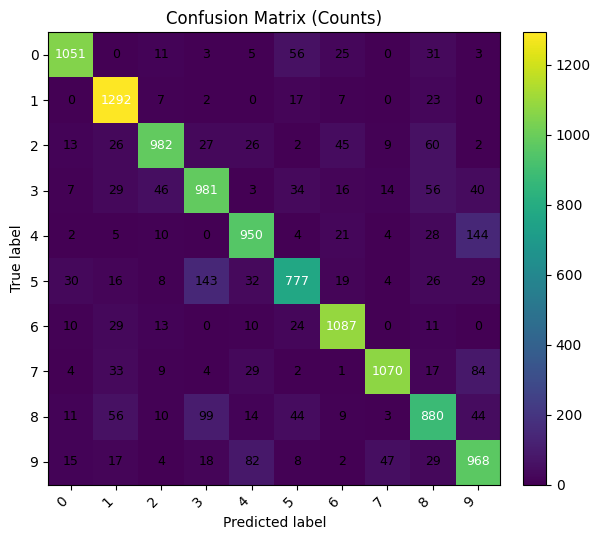

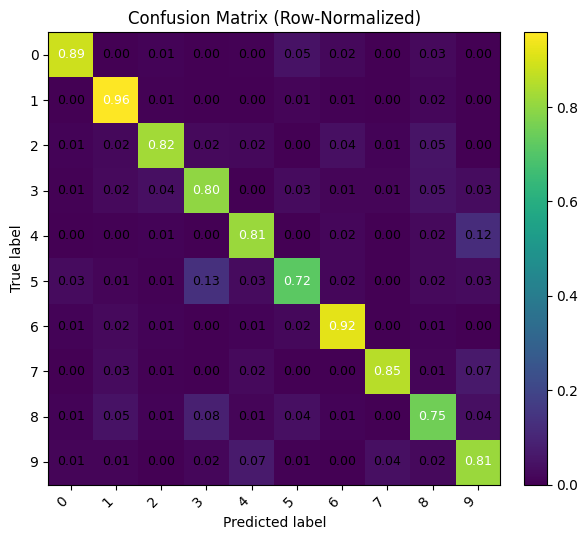

In [104]:
x_train_bin = binarize(x_train, 0.5)
x_test_bin  = binarize(x_test, 0.5)

alpha = 1.0 
priors, theta = fit_bernoulli(x_train_bin, y_train, n_classes=10, alpha=alpha)

y_pred = predict_bernoulli(x_test_bin, priors, theta, batch_size=4096)

def confusion_matrix_np(y_true, y_pred, n_classes=10):
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm  = confusion_matrix_np(y_test, y_pred, n_classes=10)

def plot_confusion_matrix(cm, class_names=None, normalize=False, title="Confusion Matrix"):
    cm_to_show = cm.astype(np.float64)
    if normalize:
        row_sums = cm_to_show.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_to_show = cm_to_show / row_sums

    C = cm.shape[0]
    if class_names is None:
        class_names = [str(i) for i in range(C)]

    plt.figure(figsize=(6.5, 5.5))
    im = plt.imshow(cm_to_show, interpolation='nearest')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(np.arange(C), class_names, rotation=45, ha='right')
    plt.yticks(np.arange(C), class_names)

    thresh = cm_to_show.max() / 2.0 if cm_to_show.size else 0
    for i in range(C):
        for j in range(C):
            if normalize:
                txt = f"{cm_to_show[i, j]:.2f}"
            else:
                txt = f"{int(cm[i, j])}"
            plt.text(j, i, txt,
                     ha="center", va="center",
                     fontsize=9,
                     color="white" if cm_to_show[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

cm = confusion_matrix_np(y_test, y_pred, n_classes=10)
plot_confusion_matrix(cm, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, normalize=True,  title="Confusion Matrix (Row-Normalized)")



In [77]:
def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

In [78]:
for a in [0.25, 0.5, 1.0, 2.0]:
    pri, th = fit_bernoulli(x_train_bin, y_train, 10, alpha=a)
    pred = predict_bernoulli(x_test_bin, pri, th)

    print(a, accuracy(y_test, pred))


0.25 0.8376666666666667
0.5 0.8373333333333334
1.0 0.8365
2.0 0.8355


In [ ]:
def to_tensor(x, y, img=False):
    if img:
        xt = torch.from_numpy(x.astype(np.float32))       
    else:
        xt = torch.from_numpy(x.astype(np.float32))  
    yt = torch.from_numpy(y.astype(np.int64))
    return xt, yt

Linear Classifier

In [85]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim=784, n_classes=N_CLASSES):
        super().__init__()
        self.fc = nn.Linear(in_dim, n_classes)
    def forward(self, x):
        if x.dim() > 2:
            x = x.flatten(1)
        return self.fc(x)


In [100]:
def one_hot(y, n_classes=10):
    oh = torch.zeros((y.shape[0], n_classes), dtype=torch.float32)
    oh[torch.arange(y.shape[0]), y] = 1.0
    return oh

def train_linear(model, xtr, ytr, xte, yte, epochs=20, batch=128, lr=0.1):
    model = model.to(device)
    criterion = nn.MSELoss()               
    optim = torch.optim.SGD(model.parameters(), lr=lr)

    ds = TensorDataset(xtr, ytr)
    loader = DataLoader(ds, batch_size=batch, shuffle=True, num_workers=0)

    ytr_oh = one_hot(ytr, N_CLASSES).to(device)  
    yte_oh = one_hot(yte, N_CLASSES).to(device)

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb_oh = one_hot(yb, N_CLASSES).to(device)

            logits = model(xb)
            loss = criterion(logits, yb_oh)

            optim.zero_grad()
            loss.backward()
            optim.step()
            running += loss.item() * xb.size(0)

        # epoch eval
        model.eval()
        with torch.no_grad():
            tr_logits = model(xtr.to(device))
            te_logits = model(xte.to(device))
            tr_pred = tr_logits.argmax(1).cpu().numpy()
            te_pred = te_logits.argmax(1).cpu().numpy()
        tr_acc = accuracy_score(ytr.cpu().numpy(), tr_pred)
        te_acc = accuracy_score(yte.cpu().numpy(), te_pred)
        print(f"Epoch {ep} - loss {running/len(xtr):.4f} - train_acc {tr_acc:.4f} - test_acc {te_acc:.4f}")

    with torch.no_grad():
        y_pred = model(xte.to(device)).argmax(1).cpu().numpy()
    return y_pred

In [101]:
print("\nLinear Classifier")
xtr_lin, ytr_lin = to_tensor(x_train, y_train)
xte_lin, yte_lin = to_tensor(x_test,  y_test)
lin_model = LinearClassifier(in_dim=x_train.shape[1])
y_pred_lin = train_linear(lin_model, xtr_lin, ytr_lin, xte_lin, yte_lin, epochs=20, batch=128, lr=0.1)
metrics_lin = compute_metrics(y_test, y_pred_lin)
print(metrics_lin)


Linear Classifier
Epoch 1 - loss 0.0503 - train_acc 0.8369 - test_acc 0.8360
Epoch 2 - loss 0.0427 - train_acc 0.8448 - test_acc 0.8408
Epoch 3 - loss 0.0414 - train_acc 0.8505 - test_acc 0.8475
Epoch 4 - loss 0.0408 - train_acc 0.8489 - test_acc 0.8423
Epoch 5 - loss 0.0404 - train_acc 0.8476 - test_acc 0.8437
Epoch 6 - loss 0.0401 - train_acc 0.8551 - test_acc 0.8509
Epoch 7 - loss 0.0399 - train_acc 0.8535 - test_acc 0.8501
Epoch 8 - loss 0.0397 - train_acc 0.8554 - test_acc 0.8492
Epoch 9 - loss 0.0396 - train_acc 0.8544 - test_acc 0.8491
Epoch 10 - loss 0.0395 - train_acc 0.8553 - test_acc 0.8494
Epoch 11 - loss 0.0394 - train_acc 0.8545 - test_acc 0.8491
Epoch 12 - loss 0.0393 - train_acc 0.8566 - test_acc 0.8508
Epoch 13 - loss 0.0392 - train_acc 0.8511 - test_acc 0.8431
Epoch 14 - loss 0.0392 - train_acc 0.8560 - test_acc 0.8482
Epoch 15 - loss 0.0391 - train_acc 0.8551 - test_acc 0.8488
Epoch 16 - loss 0.0391 - train_acc 0.8540 - test_acc 0.8465
Epoch 17 - loss 0.0391 - train

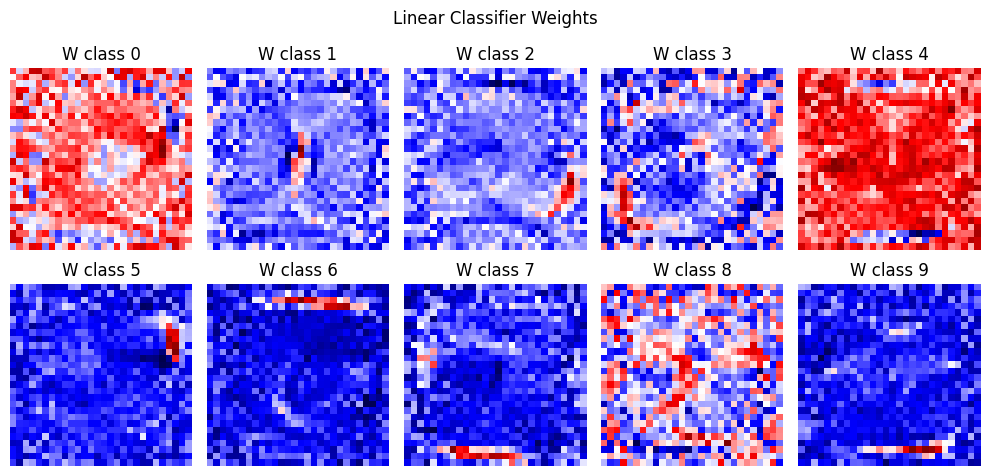

In [105]:
with torch.no_grad():
    W = lin_model.fc.weight.detach().cpu().numpy()  # (10, 784)
fig, axes = plt.subplots(2,5, figsize=(10,5))
for c, ax in enumerate(axes.ravel()):
    ax.imshow(W[c].reshape(28,28), cmap='seismic')
    ax.set_title(f"W class {c}"); ax.axis('off')
plt.suptitle("Linear Classifier Weights")
plt.tight_layout(); plt.show()

MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim=784, h1=256, h2=128, n_classes=N_CLASSES):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(inplace=True),
            nn.Linear(h1, h2),
            nn.ReLU(inplace=True),
            nn.Linear(h2, n_classes)
        )
    def forward(self, x):
        if x.dim() > 2:
            x = x.flatten(1)
        return self.net(x)

print("\nMLP")
mlp_model = MLP(in_dim=x_train.shape[1], h1=256, h2=128)
y_pred_mlp = train_classifier(mlp_model, xtr_lin, ytr_lin, xte_lin, yte_lin, epochs=20, batch=128, lr=0.1)
metrics_mlp = compute_metrics(y_test, y_pred_mlp)
print(metrics_mlp)


[ MLP ]
Epoch 01 - loss 0.7700 - train_acc 0.9006 - test_acc 0.9007
Epoch 02 - loss 0.2959 - train_acc 0.9297 - test_acc 0.9295
Epoch 03 - loss 0.2264 - train_acc 0.9449 - test_acc 0.9457
Epoch 04 - loss 0.1796 - train_acc 0.9560 - test_acc 0.9537
Epoch 05 - loss 0.1474 - train_acc 0.9626 - test_acc 0.9605
Epoch 06 - loss 0.1233 - train_acc 0.9686 - test_acc 0.9643
Epoch 07 - loss 0.1057 - train_acc 0.9746 - test_acc 0.9682
Epoch 08 - loss 0.0919 - train_acc 0.9771 - test_acc 0.9688
Epoch 09 - loss 0.0807 - train_acc 0.9786 - test_acc 0.9699
Epoch 10 - loss 0.0711 - train_acc 0.9839 - test_acc 0.9752
Epoch 11 - loss 0.0631 - train_acc 0.9861 - test_acc 0.9750
Epoch 12 - loss 0.0562 - train_acc 0.9879 - test_acc 0.9758
Epoch 13 - loss 0.0499 - train_acc 0.9887 - test_acc 0.9744
Epoch 14 - loss 0.0445 - train_acc 0.9895 - test_acc 0.9755
Epoch 15 - loss 0.0402 - train_acc 0.9929 - test_acc 0.9777
Epoch 16 - loss 0.0359 - train_acc 0.9917 - test_acc 0.9759
Epoch 17 - loss 0.0322 - train_

Epoch 1 - loss 0.5278 - train_acc 0.9553 - test_acc 0.9572
Epoch 2 - loss 0.1063 - train_acc 0.9761 - test_acc 0.9756
Epoch 3 - loss 0.0736 - train_acc 0.9824 - test_acc 0.9796
Epoch 4 - loss 0.0567 - train_acc 0.9840 - test_acc 0.9821
Epoch 5 - loss 0.0461 - train_acc 0.9882 - test_acc 0.9849
Epoch 6 - loss 0.0396 - train_acc 0.9900 - test_acc 0.9841
Epoch 7 - loss 0.0337 - train_acc 0.9929 - test_acc 0.9872
Epoch 8 - loss 0.0302 - train_acc 0.9929 - test_acc 0.9872
Epoch 9 - loss 0.0261 - train_acc 0.9930 - test_acc 0.9860
Epoch 10 - loss 0.0247 - train_acc 0.9940 - test_acc 0.9877
Epoch 11 - loss 0.0201 - train_acc 0.9946 - test_acc 0.9868
Epoch 12 - loss 0.0187 - train_acc 0.9960 - test_acc 0.9878
Epoch 13 - loss 0.0160 - train_acc 0.9973 - test_acc 0.9888
Epoch 14 - loss 0.0145 - train_acc 0.9970 - test_acc 0.9888
Epoch 15 - loss 0.0126 - train_acc 0.9975 - test_acc 0.9888
{'accuracy': 0.98875, 'precision': 0.9887668140817784, 'f1': 0.9887449257039485}


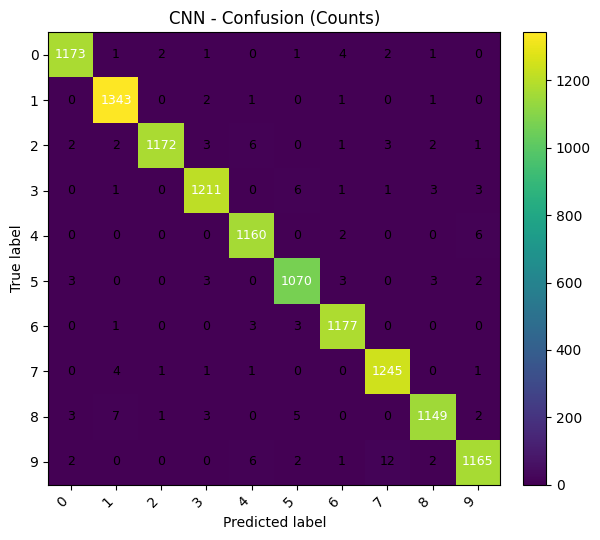

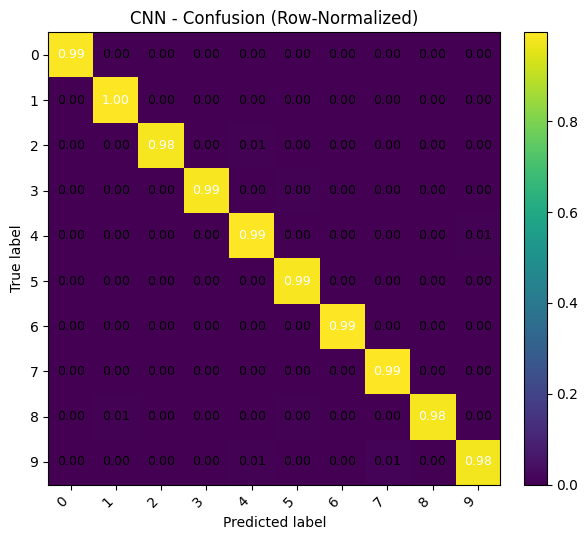

In [94]:
xtr_img = torch.from_numpy(x_train.reshape(-1, 1, 28, 28).astype(np.float32))
ytr     = torch.from_numpy(y_train.astype(np.int64))
xte_img = torch.from_numpy(x_test.reshape(-1, 1, 28, 28).astype(np.float32))
yte     = torch.from_numpy(y_test.astype(np.int64))

train_ds_cnn = TensorDataset(xtr_img, ytr)
test_ds_cnn  = TensorDataset(xte_img, yte)

train_loader_cnn = DataLoader(train_ds_cnn, batch_size=128, shuffle=True,  num_workers=0)
test_loader_cnn  = DataLoader(test_ds_cnn,  batch_size=512, shuffle=False, num_workers=0)

class SimpleCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                           
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_classes)   
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()               
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  

def eval_accuracy(loader):
    model.eval()
    correct = total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total   += yb.numel()
            y_true.append(yb.cpu().numpy())
            y_pred.append(preds.cpu().numpy())
    return correct / total, y_true, y_pred

EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader_cnn:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)            
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * xb.size(0)

    # eval_accuracy returns (accuracy, y_true_list, y_pred_list)
    tr_acc, _, _ = eval_accuracy(train_loader_cnn)
    te_acc, _, _ = eval_accuracy(test_loader_cnn)
    print(f"Epoch {epoch} - loss {running/len(train_ds_cnn):.4f} - "
          f"train_acc {tr_acc:.4f} - test_acc {te_acc:.4f}")
    
model.eval()
all_preds = []
with torch.no_grad():
    for xb, yb in test_loader_cnn:
        logits = model(xb.to(device))
        preds  = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
y_pred_cnn = np.concatenate(all_preds)
y_true_cnn = y_test

metrics_cnn = compute_metrics(y_true_cnn, y_pred_cnn)
print(metrics_cnn)

cm_cnn = confusion_matrix_np(y_true_cnn, y_pred_cnn, n_classes=10)
plot_confusion_matrix(cm_cnn, normalize=False, title="CNN - Confusion (Counts)")
plot_confusion_matrix(cm_cnn, normalize=True,  title="CNN - Confusion (Row-Normalized)")


Test Metrics
            accuracy  precision        f1
KNN(k=1)    0.971583   0.971721  0.971541
KNN(k=3)    0.971667   0.971813  0.971609
KNN(k=5)    0.971000   0.971217  0.970971
NaiveBayes  0.836500   0.838452  0.836358
Linear      0.922250   0.922086  0.922006
MLP         0.976250   0.976314  0.976210
CNN         0.988750   0.988767  0.988745


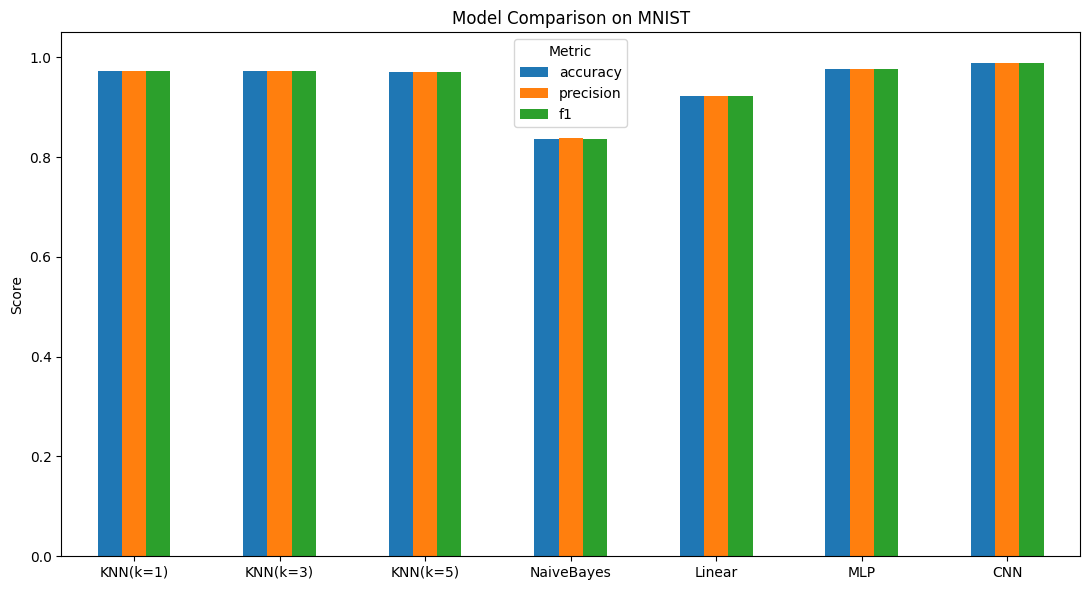

In [98]:
results = pd.DataFrame.from_dict({
    **knn_metrics, 
    "NaiveBayes":   metrics_nb,
    "Linear":       metrics_lin,
    "MLP":          metrics_mlp,
    "CNN":          metrics_cnn
}, orient="index")

print("\nTest Metrics")
print(results)

metrics_to_plot = ["accuracy", "precision", "f1"]
ax = results[metrics_to_plot].plot(kind="bar", figsize=(11,6), rot=0)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Model Comparison on MNIST")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()
